In [2]:
import pandas as pd 
import numpy as np
import seaborn as sb 
import matplotlib.pyplot as plt 
import os
import pickle
import re
from scipy.stats import wilcoxon
from sklearn.linear_model import LinearRegression


# Importing files

In [269]:
dir_path = "solution_files"

dfs = []
pattern = r'_B(\d+)_F(\d+)_'

for file in os.listdir(dir_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(dir_path, file))
        df['instance'] = file
        if "Factivel" in file:
            df['category'] = "Deterministic"
            df['gamma'] = 0
            df['uncertainty'] = 0

        elif "soyster" in file: 
            continue
            df['category'] = "Soyster"
            df['gamma'] = -1
            df['uncertainty'] = 0.1
        else:
            df['category'] = 'robust_test'
            df['gamma'] = 10
            df['uncertainty'] = 0.1        

        match = re.search(pattern, file)
        if match:
            df['blocks'] = int(match.group(1))
            df['fronts'] = int(match.group(2))
        else:
            df['blocks'] = None
            df['fronts'] = None
        
        dfs.append(df)

full = pd.concat(dfs, ignore_index=True)
full = full.drop(columns={'Unnamed: 0'})

def extract_instance_id(instance_name):
    match = re.search(r'(Factivel|Robusta)(\d+)', instance_name)
    return int(match.group(2)) if match else None

full['instance_id'] = full['instance'].apply(extract_instance_id)

soyster = pd.read_csv('soyster.csv')
soyster['blocks'] = soyster['instance'].apply(lambda x: int(re.search(pattern, x).group(1)) if re.search(pattern, x) else None)
soyster['fronts'] = soyster['instance'].apply(lambda x: int(re.search(pattern, x).group(2)) if re.search(pattern, x) else None)

soyster = soyster.drop(columns='timestamp')

full = pd.merge(full,soyster,how='outer')
full

,objective_value,termination_condition,number_of_variables,number_of_constraints,mip_gap,runtime,best_bound,node_count,instance,category,gamma,uncertainty,blocks,fronts,instance_id
0,9.592306e+06,optimal,665579,110793,0.000084,15.141037,9.591502e+06,NaN,Robusta40_B28_F4_T9_28_4_9robust.csv,robust_test,10,0.1,28,4,40
1,9.960747e+06,optimal,712317,114719,0.000081,12.256295,9.959943e+06,NaN,Robusta41_B29_F4_T9_29_4_9robust.csv,robust_test,10,0.1,29,4,41
2,9.965934e+06,optimal,760639,118645,0.000097,15.716904,9.964970e+06,NaN,Robusta42_B30_F4_T9_30_4_9robust.csv,robust_test,10,0.1,30,4,42
3,1.004012e+07,optimal,760639,118375,0.000081,12.972841,1.003931e+07,NaN,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,Soyster,-1,0.1,30,4,42
4,1.009615e+07,optimal,570559,89068,0.000066,9.251811,1.009548e+07,NaN,Robusta21_B30_F3_T9_30_3_9robust.csv,robust_test,10,0.1,30,3,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1.358047e+07,optimal,118819,50031,0.000070,0.755762,1.357951e+07,NaN,Factivel43_B10_F5_T9.csv,Deterministic,0,0.0,10,5,43
155,1.359083e+07,optimal,177431,55702,0.000056,2.060606,1.359006e+07,NaN,Factivel26_B14_F4_T9.csv,Deterministic,0,0.0,14,4,26
156,1.360892e+07,optimal,95059,40034,0.000088,0.703648,1.360772e+07,NaN,Factivel2_B10_F4_T9.csv,Deterministic,0,0.0,10,4,2
157,1.365448e+07,optimal,95059,40034,0.000047,0.554471,1.365384e+07,NaN,Factivel22_B10_F4_T9.csv,Deterministic,0,0.0,10,4,22


# Example solution


In [12]:
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import TerminationCondition, SolverStatus
from model import GLSP_model

import pickle

# Define sets
F = range(1, 4)  # Fronts: 1, 2, 3
B = range(1, 11)  # Blocks: 1 to 10
S = range(1, 9 * 22 + 1)  # Microperiods: 1 to 198

# Load the results
with open('instance_objects/instance_Factivel1_B10_F3_T9_10_3_9_202507081553.pkl', 'rb') as f:
    instance = pickle.load(f)

model = GLSP_model(instance)

results, stats = model.solve()




Params ok!
Vars ok!
OBJ OK
2 and 3 OK
4 OK
5 OK
6 OK
7 OK
8 OK
9 OK
10 OK
11 OK
12 OK
13 OK
Model was built!
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-23
Set parameter TimeLimit to value 600
Set parameter SoftMemLimit to value 13.2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "openSUSE Tumbleweed")

CPU model: Intel(R) Core(TM) i7-10610U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30037 rows, 71299 columns and 241540 nonzeros
Model fingerprint: 0x15b19f2c
Variable types: 5959 continuous, 65340 integer (65340 binary)
Coefficient statistics:
  Matrix range     [5e-03, 4e+04]
  Objective range  [3e+00, 2e+02]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+00, 2e+05]
Presolve removed 26420 rows and 67759 columns
Presolve time: 0.32s
Presolved: 3617 rows, 3540 columns, 21038 nonzeros
Variable types: 2757 continuous, 783 

In [37]:
x = []
y = []
z  = []
wm = []
wb = []
for var in model.model.component_objects(pyo.Var):
    var_name = var.name
    for index, value in var.get_values().items():
        if value is  None or value == 0.0:
            continue
        if var_name == "x":  # Skip None values
            x.append({
                'l': index[0],    
                'j': index[1],
                's': index[2],
                'Value': value
            })
            continue

        if var_name == 'y':
            y.append({
                'l': index[0],    
                'j': index[1],
                's': index[2],
                'Value': value
            })
        
        if var_name == 'z':
            z.append({
                'l': index[0],    
                'i': index[1],
                'j': index[2],
                's': index[3],
                'Value': value
            })
        if var_name == 'wm':
            wm.append({'t': index, 'value':value})
        
        if var_name == 'wb':
            wm.append({'j': index, 'value':value})

x = pd.DataFrame(x, columns=['l', 'j','s', 'Value'])
y = pd.DataFrame(y,columns=['l', 'j','s', 'Value'])
z = pd.DataFrame(z,columns=['l','i' ,'j','s', 'Value'])
wm = pd.DataFrame(wm,columns=['t', 'Value'])
wb = pd.DataFrame(wb,columns=['j', 'Value'])


z

,l,i,j,s,Value
0,1,3,3,1,1.0
1,1,3,3,2,1.0
2,1,3,3,3,1.0
3,1,3,3,4,1.0
4,1,3,3,5,1.0
...,...,...,...,...,...
589,3,10,10,194,1.0
590,3,10,10,195,1.0
591,3,10,10,196,1.0
592,3,10,10,197,1.0


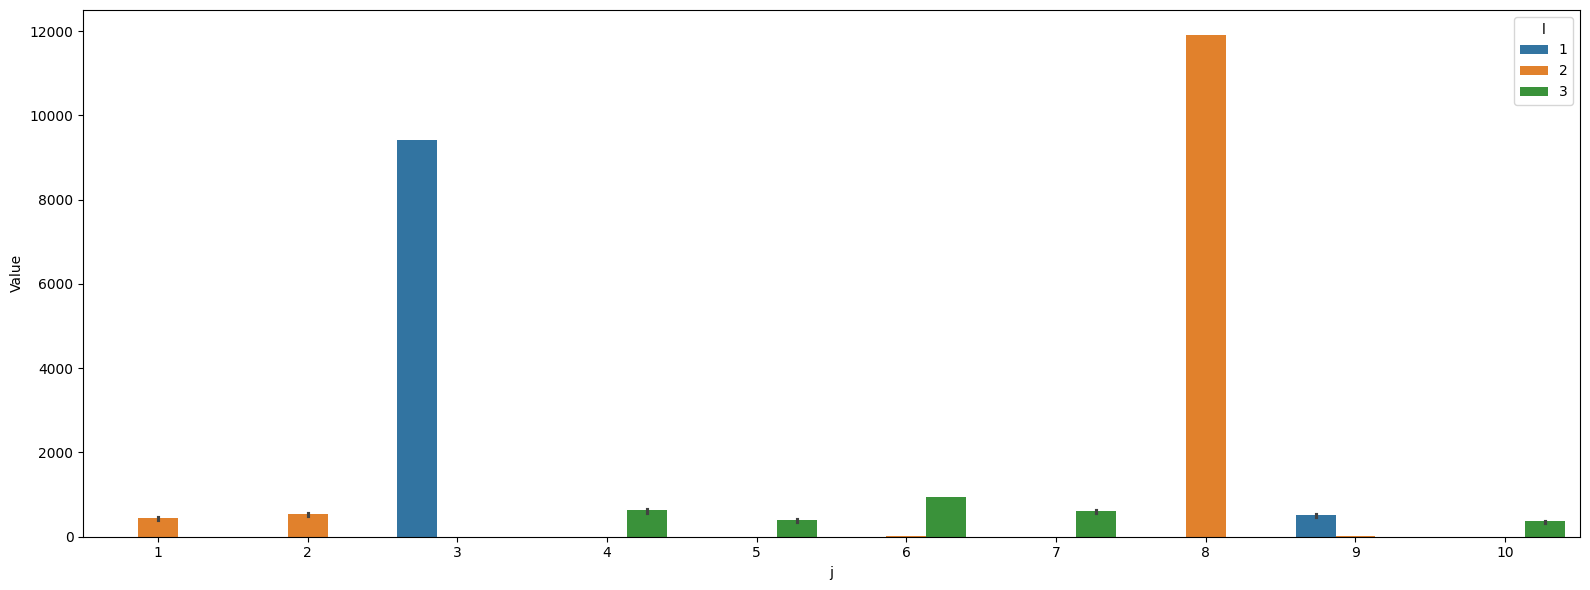

In [55]:
F = y['l'].unique()
B = y['j'].unique()
S = y['s'].unique()
custom_cmap = sb.color_palette(["#1F77B4", "#FF7F0E", "#2CA02C"])
plt.figure(figsize=(16,9/1.5))
sb.barplot(x,x='j',y='Value',hue='l',palette=custom_cmap)
plt.tight_layout()
plt.show()

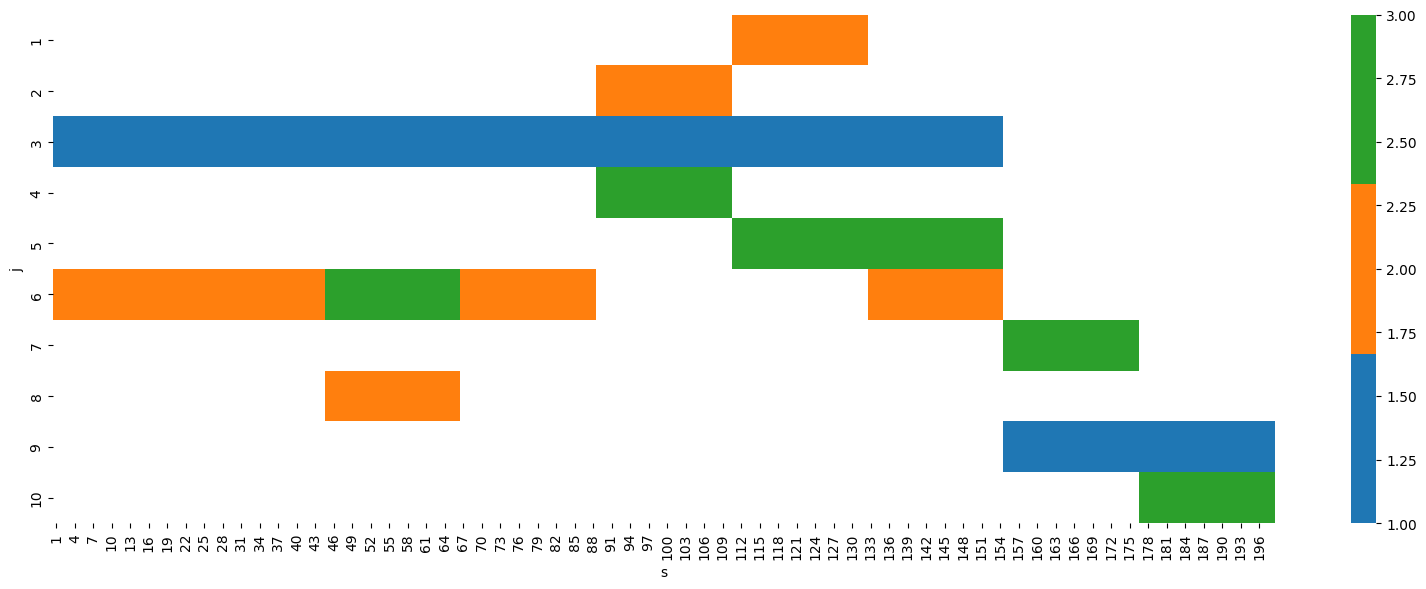

s,1,2,3,4,5,6,7,8,9,10,...,189,190,191,192,193,194,195,196,197,198
j,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
pivot_y = pd.pivot_table(y,index='j',columns='s',values='l',aggfunc='first')
custom_cmap = sb.color_palette(["#1F77B4", "#FF7F0E", "#2CA02C"])
plt.figure(figsize=(16,9/1.5))
sb.heatmap(pivot_y,cmap=custom_cmap)
plt.tight_layout()
plt.grid(False)
plt.show()
pivot_y

# Gamma e delta

In [244]:
robust_stats = pd.read_csv('robust_stats.csv')

robust_stats['blocks'] = robust_stats['instance'].apply(lambda x: int(re.search(pattern, x).group(1)) if re.search(pattern, x) else None)
robust_stats['fronts'] = robust_stats['instance'].apply(lambda x: int(re.search(pattern, x).group(2)) if re.search(pattern, x) else None)

display(robust_stats.sample(5))


,objective_value,termination_condition,number_of_variables,number_of_constraints,mip_gap,runtime,best_bound,node_count,gamma,uncertainty,instance,category,blocks,fronts
41,1.048606e+07,optimal,760639,118645,0.000099,12.964646,1.048501e+07,NaN,25.0,0.3,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4
30,9.965934e+06,optimal,760639,118645,0.000097,13.420182,9.964970e+06,NaN,10.0,0.1,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4
11,1.040710e+07,optimal,570559,89068,0.000087,7.537755,1.040620e+07,NaN,10.0,0.3,instance_Factivel21_B30_F3_T9_30_3_9_202507081...,robust,30,3
20,1.063634e+07,optimal,570559,89068,0.000055,34.835591,1.063576e+07,NaN,25.0,0.3,instance_Factivel21_B30_F3_T9_30_3_9_202507081...,robust,30,3
29,1.007476e+07,optimal,760639,118645,0.000068,17.010826,1.007408e+07,NaN,5.0,0.3,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4


/tmp/ipykernel_552990/812655726.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=robust_stats, x='gamma', y='objective_value',palette='tab20')


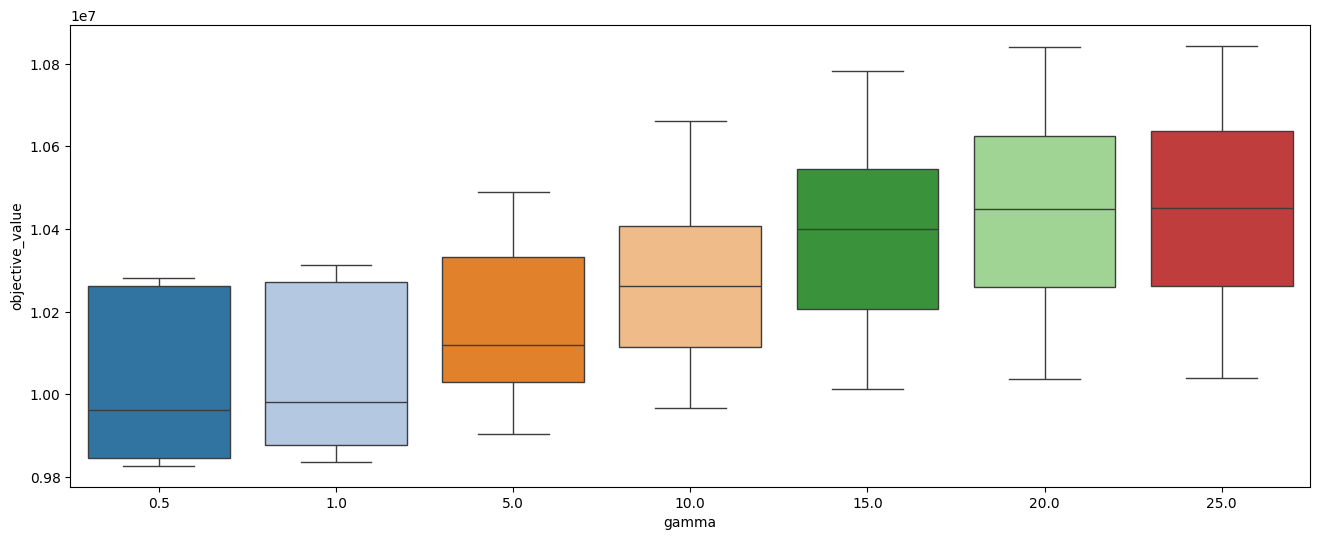

In [245]:
fig = plt.figure(figsize=(16, 9/1.5))
sb.boxplot(data=robust_stats, x='gamma', y='objective_value',palette='tab20')
plt.show()

/tmp/ipykernel_552990/1751257172.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(robust_stats,x='uncertainty',y='objective_value',palette='tab20')


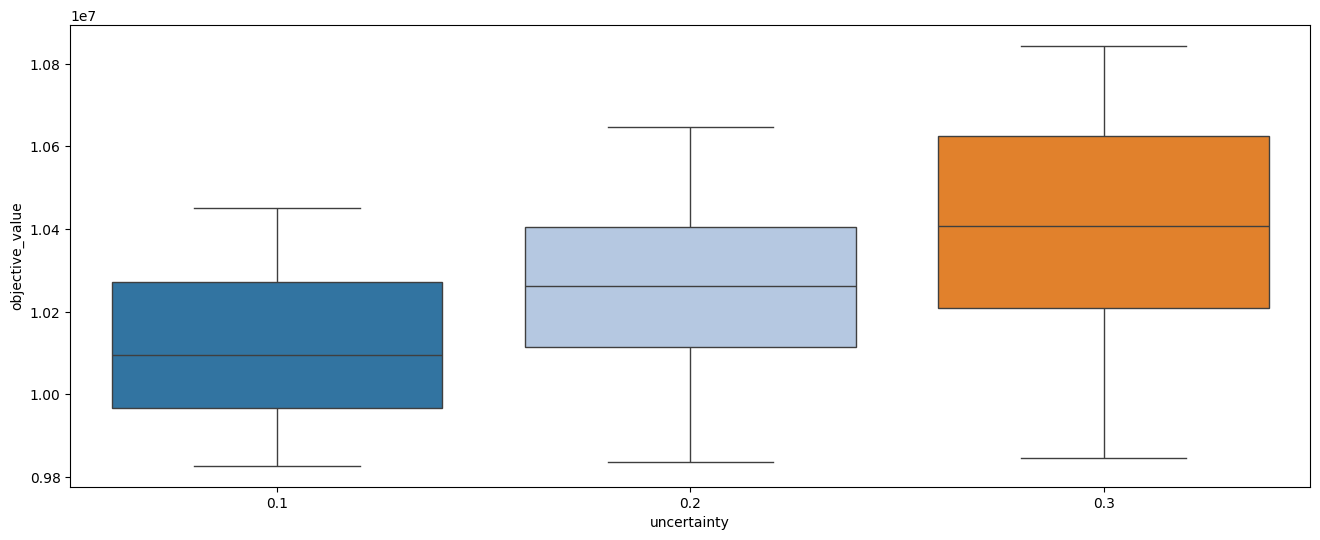

In [276]:
fig = plt.figure(figsize=(16, 9/1.5))
sb.boxplot(robust_stats,x='uncertainty',y='objective_value',palette='tab20')
plt.show()

# Soyster

# Determinístic

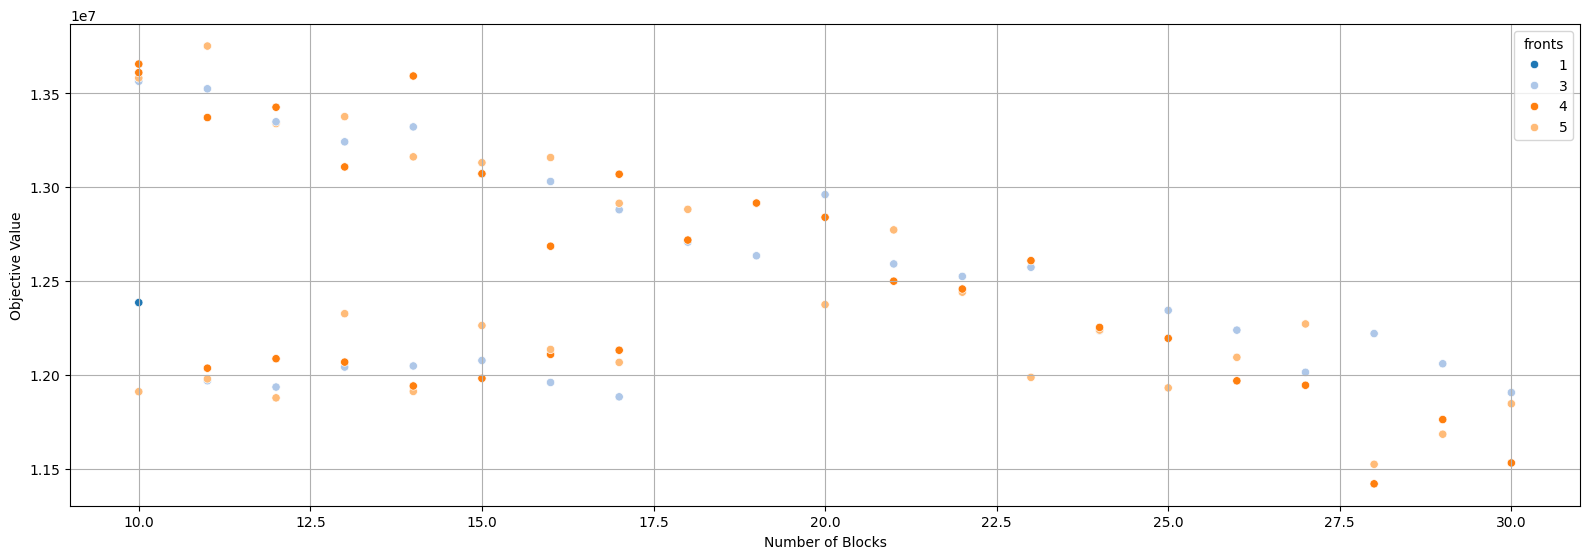


### Statistical Summary by Blocks and Fronts ###
    blocks  fronts     obj_mean     obj_std  instance_count  runtime_mean  \
0       10       1  12384604.27         NaN               1          1.05   
1       10       3  13562772.89         NaN               1          0.73   
2       10       4  13631699.85    32220.64               2          0.63   
3       10       5  12745357.48  1181021.14               2          0.85   
4       11       3  12745635.05  1098992.42               2          1.58   
..     ...     ...          ...         ...             ...           ...   
59      29       4  11761864.38         NaN               1         10.29   
60      29       5  11683812.70         NaN               1         23.12   
61      30       3  11905557.16         NaN               1         13.09   
62      30       4  11530806.32         NaN               1         14.81   
63      30       5  11846119.15         NaN               1         12.60   

    runtime_std  vars_mea

In [248]:



det_data = full[full['category'] == 'Deterministic'][['instance_id', 'blocks', 'fronts', 'objective_value', 'runtime', 'number_of_variables']]

grouped = det_data.groupby(['blocks', 'fronts']).agg({
    'objective_value': ['mean', 'std', 'count'],
    'runtime': ['mean', 'std'],
    'number_of_variables': ['mean', 'std']
}).reset_index()

grouped.columns = ['blocks', 'fronts', 'obj_mean', 'obj_std', 'instance_count', 'runtime_mean', 'runtime_std', 'vars_mean', 'vars_std']
fig, axes = plt.subplots(1, 1, figsize=(16, 9/1.5))

sb.scatterplot(ax=axes, data=det_data, x='blocks', y='objective_value', hue='fronts',palette='tab20')
axes.set_xlabel('Number of Blocks')
axes.set_ylabel('Objective Value')
axes.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n### Statistical Summary by Blocks and Fronts ###")
print(grouped.round(2))


# Joint Analysis

In [249]:

robust_stats['instance_id'] = robust_stats['instance'].apply(extract_instance_id)

full = pd.merge(robust_stats,full,how='outer')

/tmp/ipykernel_552990/3692643565.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  full = pd.merge(robust_stats,full,how='outer')


,Deterministic_objective,Soyster_objective,robust_objective,robust_test_objective
instance_id,,,,
21,1.190556e+07,1.040467e+07,1.020820e+07,1.009615e+07
42,1.153081e+07,1.026296e+07,1.007508e+07,9.965934e+06
63,1.184612e+07,1.064657e+07,1.048544e+07,1.038879e+07


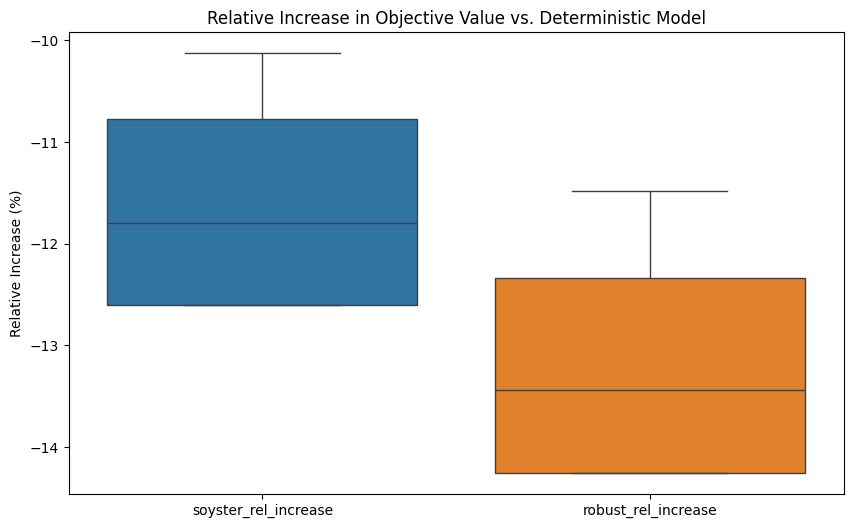

Wilcoxon test p-value (Soyster vs Robust relative increase): 0.1250


In [260]:
pivot_obj = full[full['blocks'] == 30].pivot_table(index='instance_id', columns='category', values='objective_value', aggfunc='mean')
pivot_obj.columns = [f'{col}_objective' for col in pivot_obj.columns]
display(pivot_obj)
pivot_runtime = full.pivot_table(index='instance_id', columns='category', values='runtime', aggfunc='mean')
pivot_runtime.columns = [f'{col}_runtime' for col in pivot_runtime.columns]

pivot_df = pd.merge(pivot_obj, pivot_runtime, left_index=True, right_index=True)

pivot_df['soyster_rel_increase'] = (pivot_df['Soyster_objective'] - pivot_df['Deterministic_objective']) / pivot_df['Deterministic_objective'] * 100
pivot_df['robust_rel_increase'] = (pivot_df['robust_objective'] - pivot_df['Deterministic_objective']) / pivot_df['Deterministic_objective'] * 100

instance_info = full[full['category'] == 'Deterministic'][['instance_id', 'blocks', 'fronts']].drop_duplicates()
pivot_df = pd.merge(pivot_df, instance_info, on='instance_id')

plt.figure(figsize=(10, 6))
sb.boxplot(data=pivot_df[['soyster_rel_increase','robust_rel_increase']])
plt.title('Relative Increase in Objective Value vs. Deterministic Model')
plt.ylabel('Relative Increase (%)')
plt.show()

stat, p = wilcoxon(pivot_df['soyster_rel_increase'].dropna(), pivot_df['robust_rel_increase'].dropna())
print(f"Wilcoxon test p-value (Soyster vs Robust relative increase): {p:.4f}")



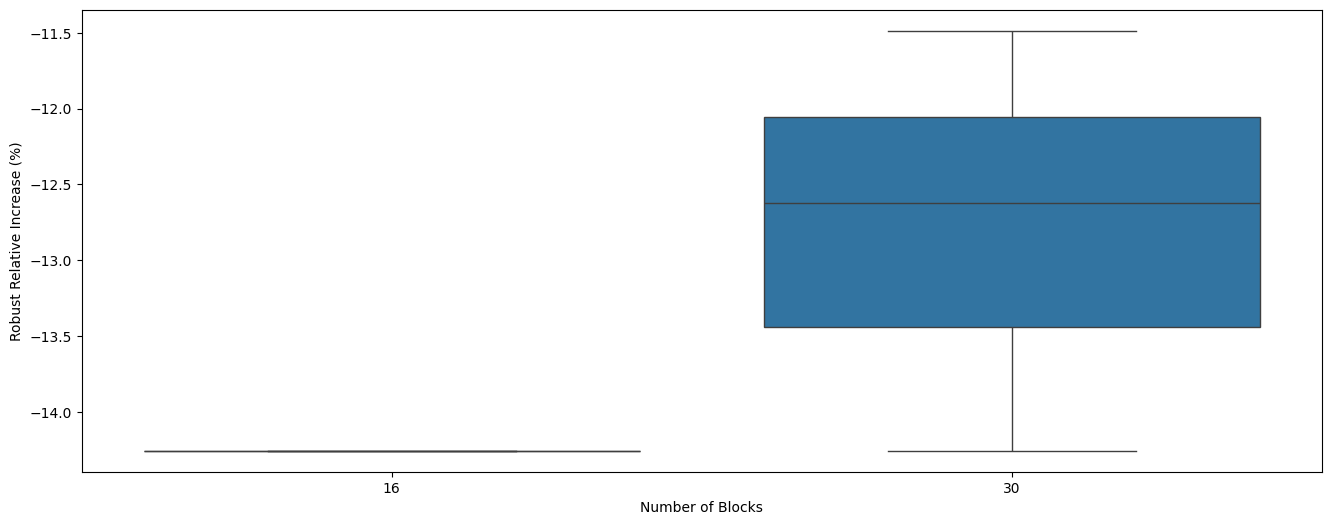

,instance_id,Deterministic_objective,Soyster_objective,robust_objective,robust_test_objective,Deterministic_runtime,Soyster_runtime,robust_runtime,robust_test_runtime,soyster_rel_increase,robust_rel_increase,blocks,fronts
0,21,1.190556e+07,1.040467e+07,1.020820e+07,1.009615e+07,7.526922,9.314888,10.777315,9.251811,-12.606600,-14.256844,30,3
1,21,1.190556e+07,1.040467e+07,1.020820e+07,1.009615e+07,7.526922,9.314888,10.777315,9.251811,-12.606600,-14.256844,16,5
2,42,1.153081e+07,1.026296e+07,1.007508e+07,9.965934e+06,14.808200,15.253898,14.663109,15.716904,-10.995271,-12.624677,30,4
3,63,1.184612e+07,1.064657e+07,1.048544e+07,1.038879e+07,12.598427,16.333283,14.108051,15.624970,-10.126089,-11.486259,30,5


In [261]:
plt.figure(figsize=(16, 9/1.5))
sb.boxplot(data=pivot_df, x='blocks', y='robust_rel_increase')
plt.xlabel('Number of Blocks')
plt.ylabel('Robust Relative Increase (%)')
plt.show()
pivot_df

In [262]:
X = pivot_df[['blocks', 'fronts']]
y = pivot_df['robust_rel_increase']
model = LinearRegression().fit(X, y)
print(f"\nRegression on Robust Relative Increase:")
print(f"Coefficients: blocks={model.coef_[0]:.4f}, fronts={model.coef_[1]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {model.score(X, y):.4f}")


Regression on Robust Relative Increase:
Coefficients: blocks=0.2038, fronts=1.3853
Intercept: -24.4437
R-squared: 0.9926


In [263]:
X = pivot_df[['blocks', 'fronts']]
y = pivot_df['robust_rel_increase']
model = LinearRegression().fit(X, y)
print(f"\nRegression on Robust Relative Increase:")
print(f"Coefficients: blocks={model.coef_[0]:.4f}, fronts={model.coef_[1]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {model.score(X, y):.4f}")


Regression on Robust Relative Increase:
Coefficients: blocks=0.2038, fronts=1.3853
Intercept: -24.4437
R-squared: 0.9926


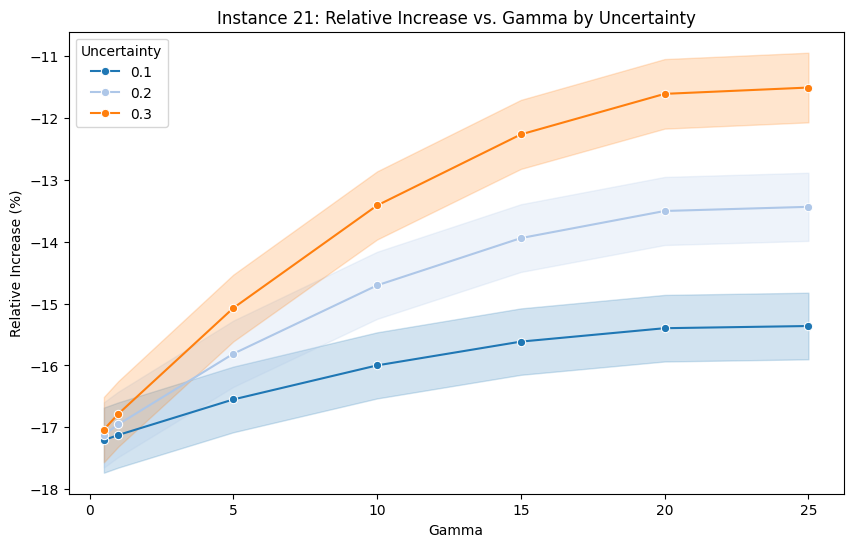

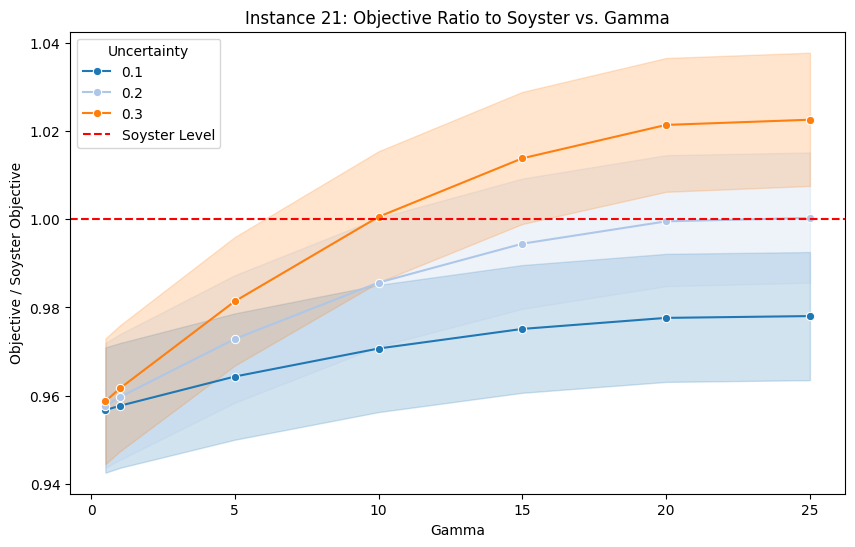

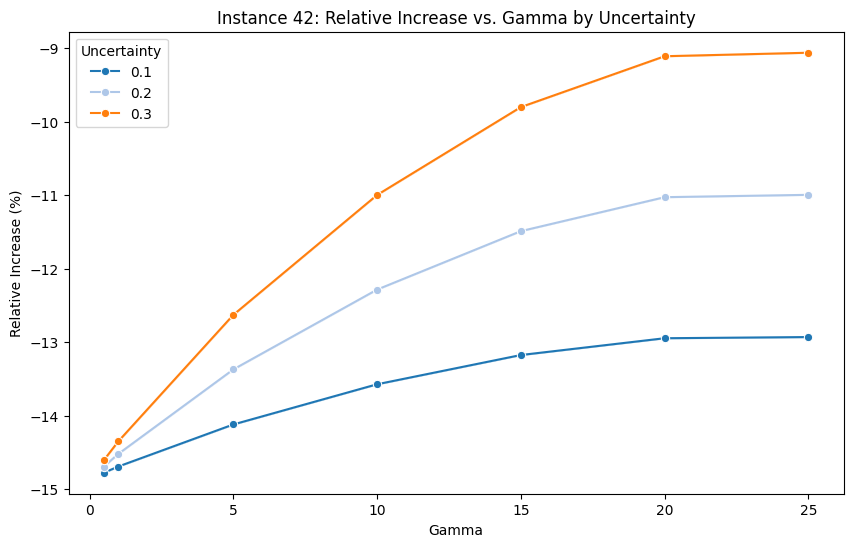

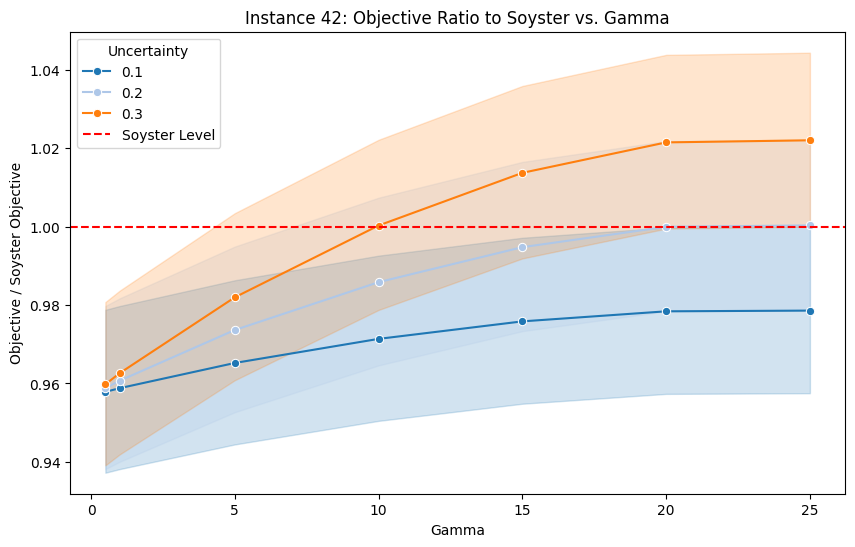

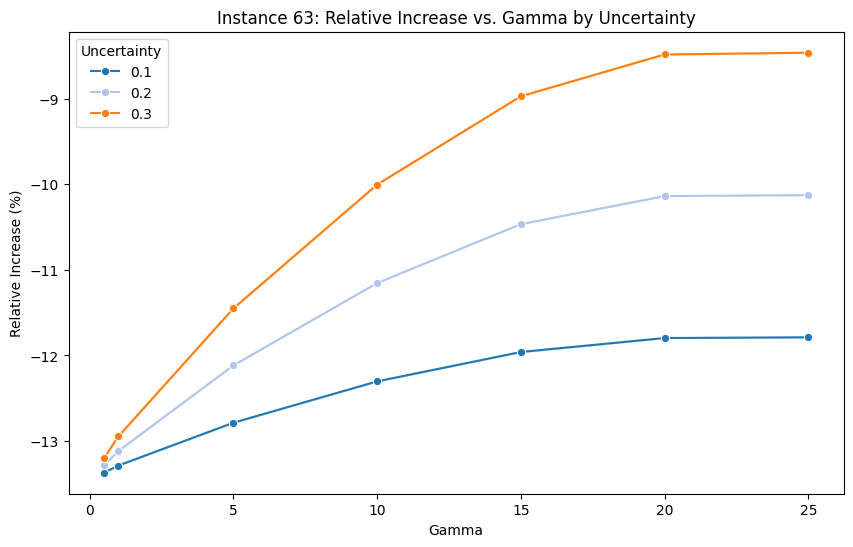

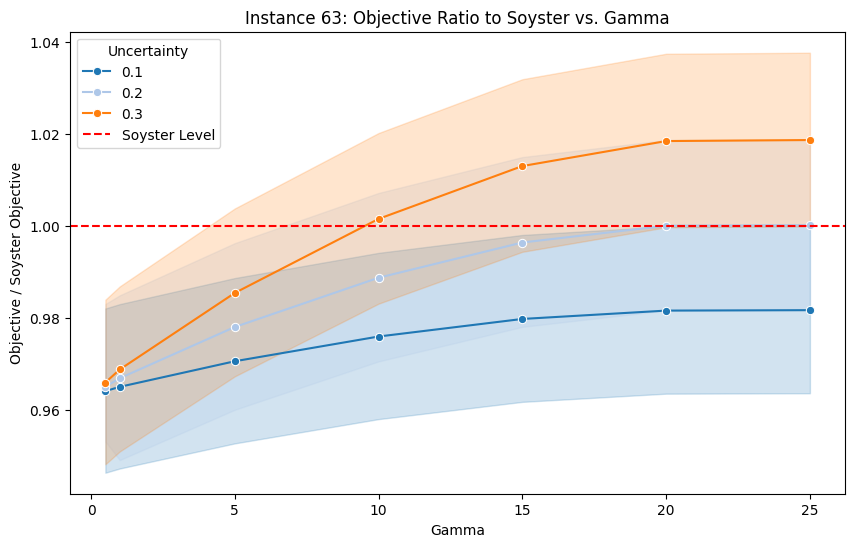

In [264]:
det_objectives = full[full['category'] == 'Deterministic'][['instance_id', 'objective_value']].rename(columns={'objective_value': 'det_objective'})
soyster_objectives = full[full['category'] == 'Soyster'][['instance_id', 'objective_value']].rename(columns={'objective_value': 'soyster_objective'})
robust_stats_merged = pd.merge(robust_stats, det_objectives, on='instance_id')
robust_stats_merged = pd.merge(robust_stats_merged, soyster_objectives, on='instance_id')

robust_stats_merged['rel_increase'] = (robust_stats_merged['objective_value'] - robust_stats_merged['det_objective']) / robust_stats_merged['det_objective'] * 100
robust_stats_merged['to_soyster_ratio'] = robust_stats_merged['objective_value'] / robust_stats_merged['soyster_objective']


for instance_id in robust_stats_merged['instance_id'].unique():
    instance_data = robust_stats_merged[robust_stats_merged['instance_id'] == instance_id]
    
    plt.figure(figsize=(10, 6))
    sb.lineplot(data=instance_data, x='gamma', y='rel_increase', hue='uncertainty', marker='o',palette='tab20')
    plt.title(f'Instance {instance_id}: Relative Increase vs. Gamma by Uncertainty')
    plt.xlabel('Gamma')
    plt.ylabel('Relative Increase (%)')
    plt.legend(title='Uncertainty')
    plt.show()
    
    # Visualization 4: Convergence to Soyster solution
    plt.figure(figsize=(10, 6))
    sb.lineplot(data=instance_data, x='gamma', y='to_soyster_ratio', hue='uncertainty', marker='o',palette='tab20')
    plt.axhline(y=1, color='r', linestyle='--', label='Soyster Level')
    plt.title(f'Instance {instance_id}: Objective Ratio to Soyster vs. Gamma')
    plt.xlabel('Gamma')
    plt.ylabel('Objective / Soyster Objective')
    plt.legend(title='Uncertainty')
    plt.show()


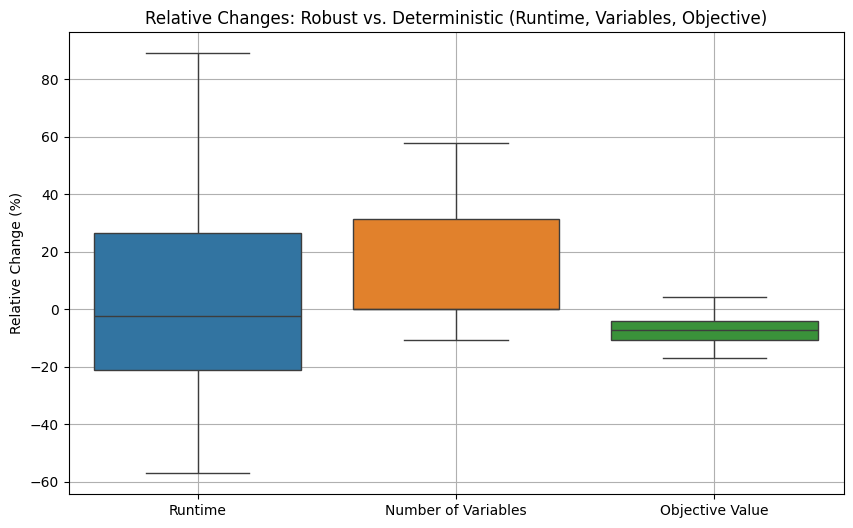

Wilcoxon test p-value (number_of_variables: Deterministic vs. Robust): 0.0000


In [270]:
det_data = full[full['category'] == 'Deterministic'][['instance_id', 'blocks', 'fronts', 'objective_value', 'runtime', 'number_of_variables']]
robust_data = full[(full['category'] == 'robust') | (full['category'] == 'robust_test')][['instance_id', 'objective_value', 'runtime', 'number_of_variables']].rename(
    columns={'objective_value': 'robust_objective', 'runtime': 'robust_runtime', 'number_of_variables': 'robust_num_variables'}
)

comparison_df = pd.merge(det_data, robust_data, on='instance_id', suffixes=('_det', '_robust'))


comparison_df['runtime_rel_change'] = (comparison_df['robust_runtime'] - comparison_df['runtime']) / comparison_df['runtime'] * 100
comparison_df['vars_rel_change'] = (comparison_df['robust_num_variables'] - comparison_df['number_of_variables']) / comparison_df['number_of_variables'] * 100
comparison_df['obj_rel_change'] = (comparison_df['robust_objective'] - comparison_df['objective_value']) / comparison_df['objective_value'] * 100


plt.figure(figsize=(10, 6))
sb.boxplot(data=comparison_df[['runtime_rel_change', 'vars_rel_change', 'obj_rel_change']],showfliers=False)
plt.title('Relative Changes: Robust vs. Deterministic (Runtime, Variables, Objective)')
plt.ylabel('Relative Change (%)')
plt.xticks([0, 1, 2], ['Runtime', 'Number of Variables', 'Objective Value'])
plt.grid(True)
plt.show()

stat, p_runtime = wilcoxon(comparison_df['number_of_variables'], comparison_df['robust_num_variables'])
print(f"Wilcoxon test p-value (number_of_variables: Deterministic vs. Robust): {p_runtime:.4f}")


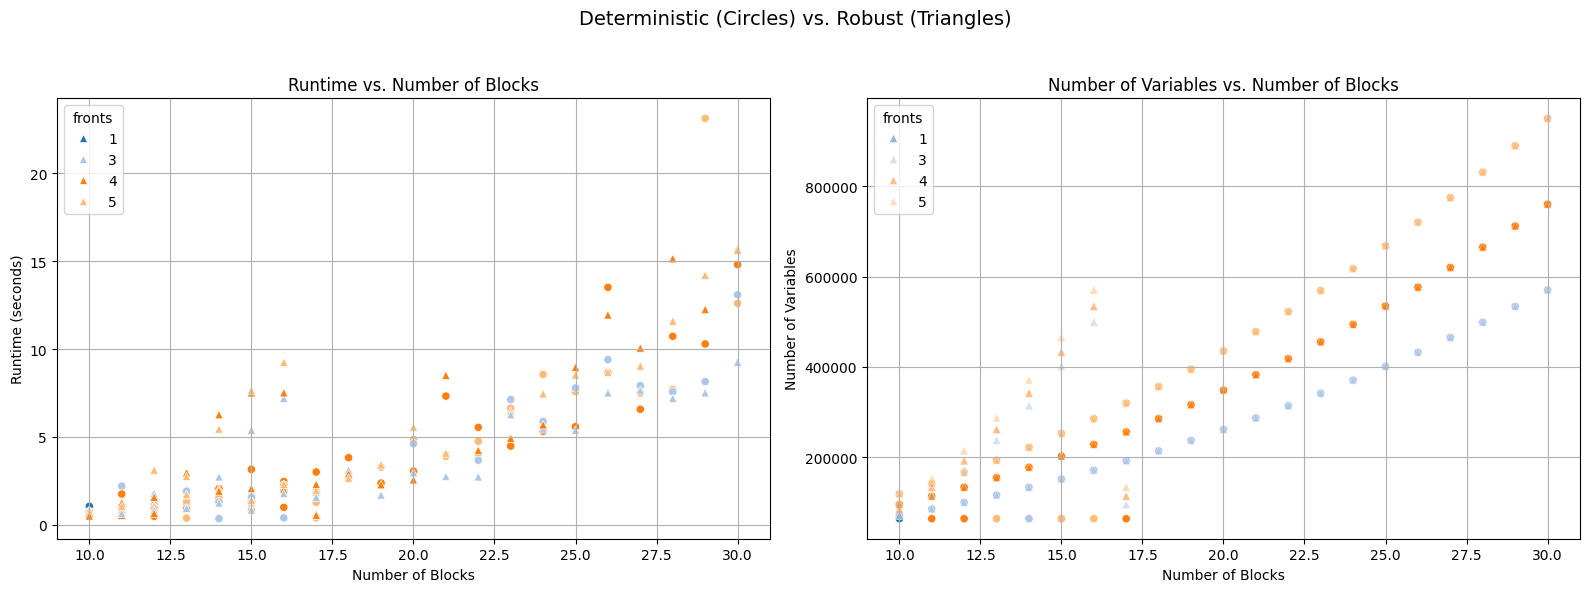

,instance_id,blocks,fronts,objective_value,runtime,number_of_variables,robust_objective,robust_runtime,robust_num_variables,runtime_rel_change,vars_rel_change,obj_rel_change
0,40,28,4,1.141961e+07,10.724969,665317,9.592306e+06,15.141037,665579,41.175579,0.039380,-16.001484
1,61,28,5,1.152368e+07,7.700485,831637,1.031040e+07,11.593087,831899,50.550091,0.031504,-10.528638
2,42,30,4,1.153081e+07,14.808200,760359,9.965934e+06,15.716904,760639,6.136491,0.036825,-13.571230
3,62,29,5,1.168381e+07,23.124626,890048,1.022348e+07,14.205530,890319,-38.569688,0.030448,-12.498792
4,41,29,4,1.176186e+07,10.289170,712046,9.960747e+06,12.256295,712317,19.118408,0.038059,-15.313193
...,...,...,...,...,...,...,...,...,...,...,...,...
82,43,10,5,1.358047e+07,0.755762,118819,1.296125e+07,0.832616,118919,10.169075,0.084162,-4.559606
83,26,14,4,1.359083e+07,2.060606,177431,1.296734e+07,1.919538,177567,-6.845946,0.076650,-4.587555
84,2,10,4,1.360892e+07,0.703648,95059,1.314588e+07,0.653818,85071,-7.081628,-10.507159,-3.402443
85,22,10,4,1.365448e+07,0.554471,95059,1.310098e+07,0.510899,95159,-7.858292,0.105198,-4.053640


In [271]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9/1.5))

sb.scatterplot(ax=axes[0], data=comparison_df, x='blocks', y='runtime', hue='fronts', legend=False,palette='tab20')
sb.scatterplot(ax=axes[0], data=comparison_df, x='blocks', y='robust_runtime', hue='fronts', marker='^', palette='tab20')
axes[0].set_title('Runtime vs. Number of Blocks')
axes[0].set_xlabel('Number of Blocks')
axes[0].set_ylabel('Runtime (seconds)')
axes[0].grid(True)


sb.scatterplot(ax=axes[1], data=comparison_df, x='blocks', y='number_of_variables', hue='fronts', legend=False,palette='tab20')
sb.scatterplot(ax=axes[1], data=comparison_df, x='blocks', y='robust_num_variables', hue='fronts', marker='^', alpha=0.5,palette='tab20')
axes[1].set_title('Number of Variables vs. Number of Blocks')
axes[1].set_xlabel('Number of Blocks')
axes[1].set_ylabel('Number of Variables')
axes[1].grid(True)



fig.suptitle('Deterministic (Circles) vs. Robust (Triangles)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

display(comparison_df)


/tmp/ipykernel_552990/1261976461.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  combined_analysis = pd.merge(robust_stats,full,how='outer')


,objective_value,termination_condition,number_of_variables,number_of_constraints,mip_gap,runtime,best_bound,node_count,gamma,uncertainty,instance,category,blocks,fronts,instance_id
1,9.827143e+06,optimal,760639,118645,0.000092,15.842406,9.826241e+06,NaN,0.5,0.1,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4,42
2,9.836855e+06,optimal,760639,118645,0.000072,18.029714,9.836142e+06,NaN,0.5,0.2,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4,42
3,9.836871e+06,optimal,760639,118645,0.000071,16.501708,9.836172e+06,NaN,1.0,0.1,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4,42
4,9.846901e+06,optimal,760639,118645,0.000096,13.180978,9.845956e+06,NaN,0.5,0.3,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4,42
5,9.856574e+06,optimal,760639,118645,0.000071,15.255999,9.855871e+06,NaN,1.0,0.2,instance_Factivel42_B30_F4_T9_30_4_9_202507081...,robust,30,4,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,1.358047e+07,optimal,118819,50031,0.000070,0.755762,1.357951e+07,NaN,0.0,0.0,Factivel43_B10_F5_T9.csv,Deterministic,10,5,43
218,1.359083e+07,optimal,177431,55702,0.000056,2.060606,1.359006e+07,NaN,0.0,0.0,Factivel26_B14_F4_T9.csv,Deterministic,14,4,26
219,1.360892e+07,optimal,95059,40034,0.000088,0.703648,1.360772e+07,NaN,0.0,0.0,Factivel2_B10_F4_T9.csv,Deterministic,10,4,2
220,1.365448e+07,optimal,95059,40034,0.000047,0.554471,1.365384e+07,NaN,0.0,0.0,Factivel22_B10_F4_T9.csv,Deterministic,10,4,22


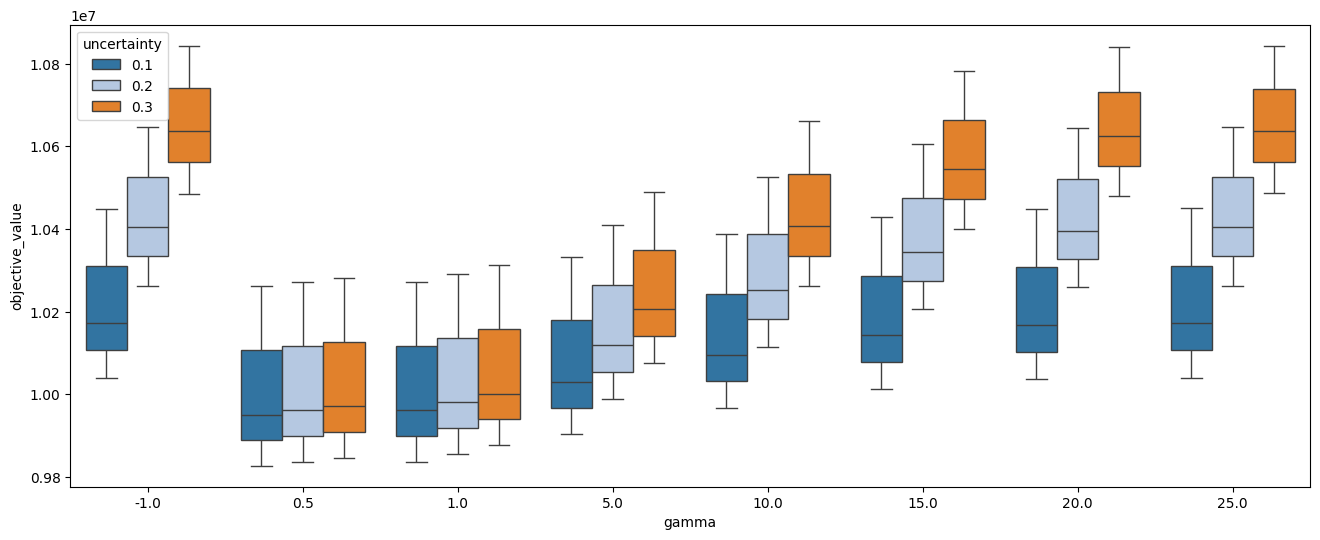

In [273]:
combined_analysis = pd.merge(robust_stats,full,how='outer')
combined_analysis = combined_analysis[combined_analysis['category'] != 'robust_test']
display(combined_analysis)

fig = plt.figure(figsize=(16, 9/1.5))
sb.boxplot(data=combined_analysis[combined_analysis['gamma'] != 0], x='gamma', y='objective_value',hue='uncertainty',palette='tab20')
plt.show()



/tmp/ipykernel_552990/4242682374.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  combined_analysis = pd.merge(robust_stats,full,how='outer')


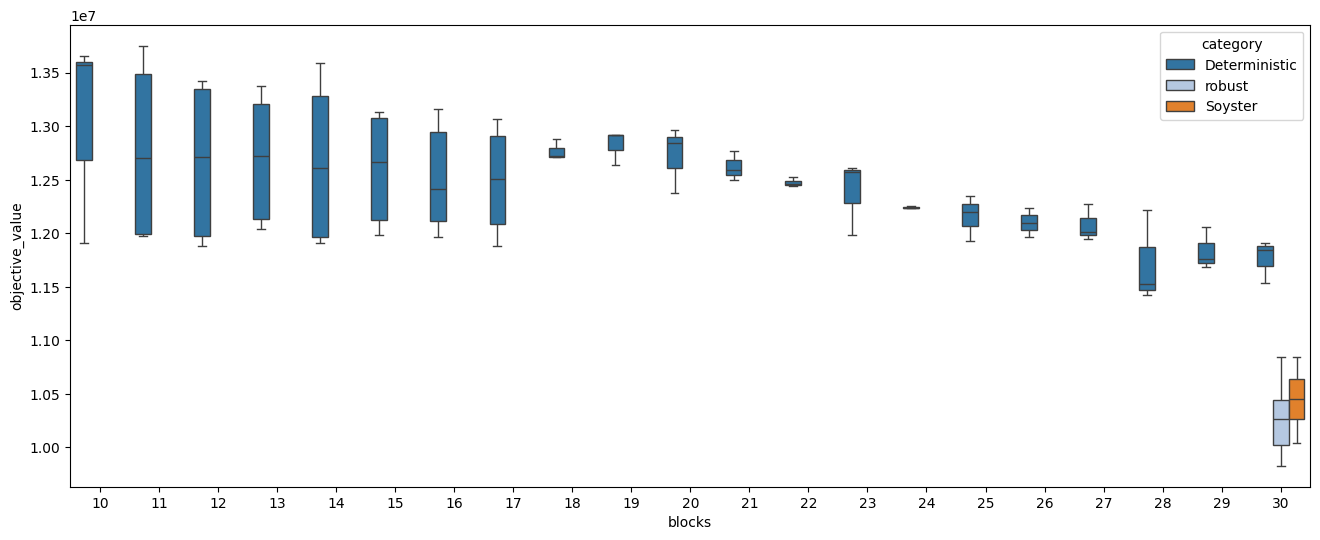

In [275]:
combined_analysis = pd.merge(robust_stats,full,how='outer')
combined_analysis = combined_analysis[combined_analysis['category'] != 'robust_test']



fig = plt.figure(figsize=(16, 9/1.5))
sb.boxplot(data=combined_analysis, x='blocks', y='objective_value',hue='category',palette='tab20')
plt.show()